# Clustering: Data Labeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import swifter

from ast import literal_eval
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample

In [2]:
indoset_lexicon_neg_path = '../dataset/wordlist/indoset_lexicon_neg.csv'
indoset_lexicon_pos_path = '../dataset/wordlist/indoset_lexicon_pos.csv'
vulgarity_lexicon_path = '../dataset/wordlist/vulgarity_lexicon.csv'

target = 'tweets.csv'
processed_target_path = f'../dataset/processed/processed_{target}'
output_path = f'../dataset/processed/supervised_{target}'

In [3]:
indoset_lexicon_neg = pd.read_csv(indoset_lexicon_neg_path, delimiter='\t')
indoset_lexicon_pos = pd.read_csv(indoset_lexicon_pos_path, delimiter='\t')
vulgarity_lexicon = pd.read_csv(vulgarity_lexicon_path, header=None, delimiter='\t')

print(f"Total lexicon neg:", len(indoset_lexicon_neg))
print(f"Total lexicon pos:", len(indoset_lexicon_pos))
print(f"Total lexicon vulgarity:", len(vulgarity_lexicon))

Total lexicon neg: 6609
Total lexicon pos: 3609
Total lexicon vulgarity: 62


In [4]:
def update_lexicon_row(row=None, col_name="", df=pd.DataFrame(), pkey=""):
	try:
		match_index = df.loc[df[pkey] == col_name].index[0]
		row = df.loc[match_index]
	except IndexError:
		pass
	finally:
		return row

def combine_lexicons(parent_lex, child_lex, pkey):
	filtered_lex = child_lex[child_lex[pkey].isin(parent_lex[pkey])]
	parent_lex[parent_lex[pkey].isin(child_lex[pkey])] = parent_lex[parent_lex[pkey].isin(child_lex[pkey])].apply(lambda row: update_lexicon_row(row, row[pkey], filtered_lex, pkey), axis=1)
	parent_lex = pd.concat([parent_lex, child_lex]).drop_duplicates(subset=[pkey])
	return parent_lex.reset_index(drop=True)

lexicon_dict = combine_lexicons(indoset_lexicon_pos, indoset_lexicon_neg, 'word')

vulgarity_lexicon_weight = [-5 for word in vulgarity_lexicon[0]]
vulgarity_lexicon = pd.DataFrame(list(zip(vulgarity_lexicon[0],vulgarity_lexicon_weight)),columns =['word','weight'])


lexicon_dict = combine_lexicons(lexicon_dict, vulgarity_lexicon, 'word')
print(len(lexicon_dict))
lexicon_dict

9112


,word,weight
0,hai,3
1,merekam,2
2,ekstensif,3
3,paripurna,1
4,detail,2
...,...,...
9107,silit,-5
9108,sintiang,-5
9109,sontoloyo,-5
9110,syaithon,-5


Total negative lexicon: 6645
Total positive lexicon: 2467


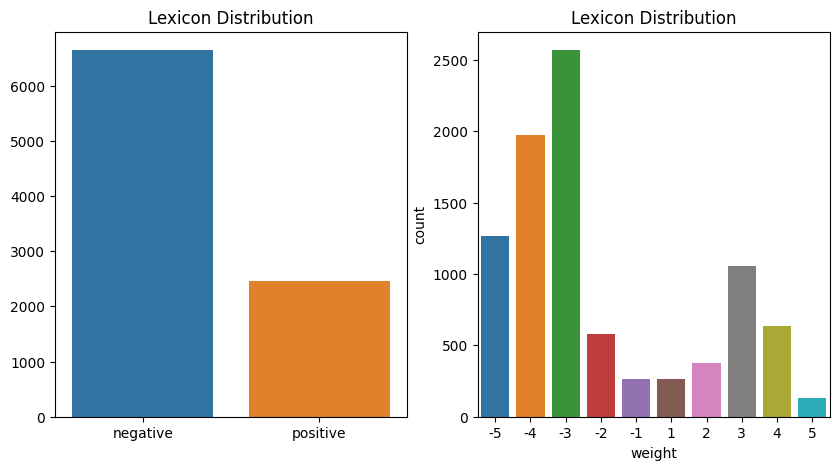

In [5]:
# count how many negative words in lexicon_dict
neg_lexicon = lexicon_dict[lexicon_dict['weight'] < 0]
pos_lexicon = lexicon_dict[lexicon_dict['weight'] >= 0]
print(f"Total negative lexicon:", len(neg_lexicon))
print(f"Total positive lexicon:", len(pos_lexicon))

plt.figure(figsize=(10,5))
# make bar plot from negative and positive lexicon
plt.subplot(1,2,1)
sns.barplot(x=['negative','positive'], y=[len(neg_lexicon), len(pos_lexicon)])
plt.title('Lexicon Distribution')
# visualize the amount of negative and positive words based on weight in lexicon_dict
plt.subplot(1,2,2)
sns.countplot(x='weight', data=lexicon_dict)
plt.title('Lexicon Distribution')
plt.show()

In [6]:
def case_folding(text):
    return text.lower()
    
def num_of_words(item):
    words = word_tokenize(item['word'])
    number = len(words)
    return number

In [7]:
lexicon_dict['word'] = lexicon_dict['word'].swifter.apply(case_folding)
lexicon_dict['num_of_words'] = lexicon_dict.swifter.apply(num_of_words, axis=1)
lexicon_dict = lexicon_dict.drop(lexicon_dict[lexicon_dict['num_of_words'] == 0].index, axis=0)
lexicon_dict.drop_duplicates(subset=['word'], keep='first',inplace=True)
lexicon_dict = lexicon_dict.reset_index(drop=True)

print(len(lexicon_dict))
lexicon_dict.sample(5)

Pandas Apply:   0%|          | 0/9112 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9112 [00:00<?, ?it/s]

9109


,word,weight,num_of_words
3449,mencemaskan,-3,1
7823,celaan,-5,1
2019,ansar,4,1
5366,umbar,-3,1
3476,bedah,-3,1


In [8]:
lexicon_dict.to_csv('../dataset/wordlist/lexicon_dict_all.csv', index=False)

lexicon_dict = lexicon_dict[lexicon_dict['num_of_words'].map(lambda x: x) < 2]
lexicon_dict

,word,weight,num_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1
...,...,...,...
9104,silit,-5,1
9105,sintiang,-5,1
9106,sontoloyo,-5,1
9107,syaithon,-5,1


In [9]:
lexicon = dict(zip(lexicon_dict['word'], lexicon_dict['weight']))
vectorizer = CountVectorizer(vocabulary=lexicon.keys(), ngram_range=(1, 1))

def detokenize(tokens):
	return TreebankWordDetokenizer().detokenize(tokens)

def determine_polarity(text):
	bow_matrix = vectorizer.fit_transform([text]).toarray()
	
	polarity = 0
	for word, score in zip(vectorizer.get_feature_names_out(), bow_matrix[0]):
		polarity += lexicon[word] * score
	return polarity

def sentiment_analyze(polarity):
	return 1 if polarity >= 0 else 0

In [10]:
df = pd.read_csv(processed_target_path, delimiter=';')

df['polarity'] = df['review'].swifter.apply(determine_polarity)
df['sentiment'] = df['polarity'].swifter.apply(sentiment_analyze)
df['label'] = df['sentiment'].swifter.apply(lambda x: 'Negative' if x < 1 else 'Positive')

df.to_csv(output_path, index=False, header=True, sep=';')

df[['content', 'tokens_ready', 'review', 'polarity', 'sentiment', 'label']]

Pandas Apply:   0%|          | 0/7079 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7079 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7079 [00:00<?, ?it/s]

,content,tokens_ready,review,polarity,sentiment,label
0,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan...,"['bukti', 'perintah', 'pro', 'rakyat', 'pro', ...",bukti perintah pro rakyat pro oligarki bbmnya ...,-7,0,Negative
1,"@KompasTV Mentri esdm, trus patokanmu apa? Kan...","['menteri', 'esdm', 'patok', 'kantong', 'jebol...",menteri esdm patok kantong jebol korupsi imbas...,-9,0,Negative
2,@hnurwahid Ngaku masih subsidi tapi ada swasta...,"['subsidi', 'swasta', 'jual', 'murah', 'subsid...",subsidi swasta jual murah subsidi pimpin tukan...,-5,0,Negative
3,@Tan_Mar3M Kalau Vivo bisaberani bertahan deng...,"['berani', 'tahan', 'harga', 'nasib']",berani tahan harga nasib,1,1,Positive
4,Menteri BUMN Erick Thohir menegaskan persiapan...,"['menteri', 'bumn', 'erick', 'thohir', 'indone...",menteri bumn erick thohir indonesia transisi e...,-3,0,Negative
...,...,...,...,...,...,...
7074,"175 Produk UMKM Binaan Pertamina Go Global, Ik...","['produk', 'umkm', 'bina', 'global', 'festival...",produk umkm bina global festival tong tong bel...,3,1,Positive
7075,"PT Pertamina Patra Niaga, Sub Holding Commerci...","['patra', 'niaga', 'sub', 'holding', 'commerci...",patra niaga sub holding commercial trading per...,6,1,Positive
7076,Pemerintah Provinsi Papua Barat sedang mengupa...,"['perintah', 'provinsi', 'papua', 'barat', 'up...",perintah provinsi papua barat upaya ajak antri...,-8,0,Negative
7077,terhitung mulai 1 September 2020 pukul 00.00 w...,"['hitung', 'september', 'resmi', 'sesuai', 'tu...",hitung september resmi sesuai turun harga prod...,9,1,Positive


Negative    4840
Positive    2239
Name: label, dtype: int64


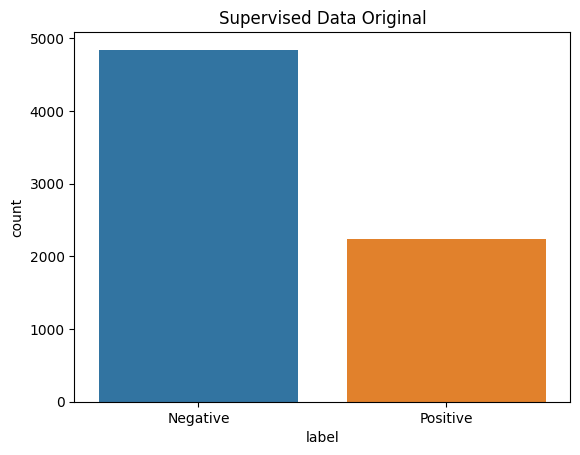

In [11]:

print(df['label'].value_counts())

# make bar plot from negative and positive lexicon
sns.countplot(x='label', data=df)
plt.title('Supervised Data Original')
plt.show()

In [12]:
def downsampling(df):
	df_minority = df[df.sentiment==1]
	df_minority_size = df_minority.shape[0]

	df_majority = df[df.sentiment==0]
	df_majority_size = df_majority.shape[0]
	df_majority_subject = df_majority.sample(n=df_minority_size, random_state=687)

	df_balanced	= pd.concat([df_majority_subject, df_minority])
	df_balanced.to_csv('../dataset/processed/supervised_tweets_downsampled.csv', index=False, header=True, sep=';')
	return df_balanced

def upsampling(df):
	df_majority = df[df.sentiment==0]
	df_minority = df[df.sentiment==1]
	df_minority_upsampled = resample(df_minority,
																			replace=True,
																			n_samples=len(df_majority),
																			random_state=687)
	df_balanced = pd.concat([df_majority, df_minority_upsampled])
	df_balanced.to_csv('../dataset/processed/supervised_tweets_upsampled.csv', index=False, header=True, sep=';')
	return df_balanced

Negative    4840
Positive    4840
Name: label, dtype: int64


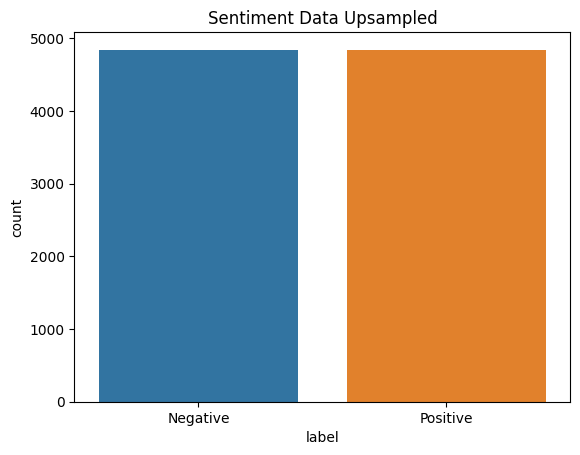

In [17]:
df_upsampled = upsampling(df)
print(df_upsampled['label'].value_counts())

# make bar plot from negative and positive sentiment
sns.countplot(x='label', data=df_upsampled)
plt.title('Sentiment Data Upsampled')
plt.show()

Negative    2239
Positive    2239
Name: label, dtype: int64


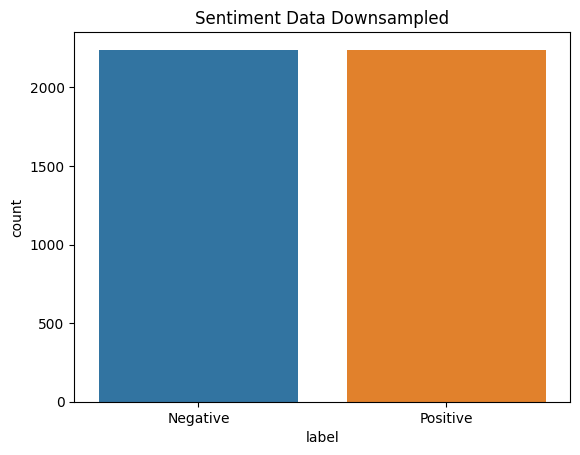

In [16]:
df_downsampled = downsampling(df)
print(df_downsampled['label'].value_counts())

# make bar plot from negative and positive sentiment
sns.countplot(x='label', data=df_downsampled)
plt.title('Sentiment Data Downsampled')
plt.show()

In [15]:
text = 'benci perintah'
print(determine_polarity(text))

-5
